<a href="https://colab.research.google.com/github/LPK224/Pipelines-de-Preprocesamiento/blob/main/Pipelines_de_Preprocesamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hotel Booking Demand (Kaggle)
## ANÁLISIS EXPLORATORIO DE DATOS Y MODELO PREDICTIVO

### 📊 Dataset
El conjunto de datos **Hotel Booking Demand** proviene de Kaggle y contiene información detallada sobre reservas hoteleras de dos tipos de hoteles: ciudad y resort.

Este es un conjunto de datos multivariado que contiene 32 variables que capturan información demográfica, temporal, de comportamiento de reserva y operacional. El dataset incluye 119,390 registros de reservas reales con datos desde 2015 hasta 2017.

### 🎯 Objetivo
El objetivo principal del análisis es predecir, a partir de las características de una reserva, si esta será **cancelada o no**, permitiendo una mejor gestión de inventario y políticas de overbooking.

### 🏷️ Variables Principales:

**Variables Temporales:**
- `lead_time`: Días de anticipación de la reserva
- `arrival_date_year`: Año de llegada
- `arrival_date_month`: Mes de llegada
- `arrival_date_week_number`: Semana del año

**Variables del Huésped:**
- `adults`: Número de adultos
- `children`: Número de niños
- `babies`: Número de bebés
- `country`: País de origen

**Variables de Reserva:**
- `hotel`: Tipo de hotel (Resort/City)
- `market_segment`: Segmento de mercado
- `distribution_channel`: Canal de distribución
- `deposit_type`: Tipo de depósito

**Variables Históricas:**
- `previous_cancellations`: Cancelaciones anteriores
- `previous_bookings_not_canceled`: Reservas previas no canceladas
- `is_repeated_guest`: ¿Cliente repetido?

**Variables Económicas:**
- `adr`: Tarifa diaria promedio
- `required_car_parking_spaces`: Espacios de parqueo requeridos

**Variable Target:**
- `is_canceled`: Estado de cancelación (0 = No cancelada, 1 = Cancelada)

Importación de librerias

In [105]:
# eda_hotel_bookings.py
# Instalar librerías si es necesario
!pip install seaborn scikit-learn

# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente")

Librerías importadas correctamente


Se carga el Dataset

In [106]:
import pandas as pd

def load_hotel_data():
    """Carga y explora el dataset de Hotel Booking Demand"""
    print("=== ANÁLISIS EXPLORATORIO - HOTEL BOOKING DEMAND ===\n")

    try:
        df = pd.read_csv("hotel_bookings.csv")
        print(" Dataset cargado exitosamente")
        print(f" Dimensiones: {df.shape}")
        print(f" Filas: {df.shape[0]}, Columnas: {df.shape[1]}")
        return df
    except FileNotFoundError:
        print(" Error: Archivo 'hotel_bookings.csv' no encontrado")
        print(" Descárgalo de: https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand")
        return None

df = load_hotel_data()

=== ANÁLISIS EXPLORATORIO - HOTEL BOOKING DEMAND ===

 Dataset cargado exitosamente
 Dimensiones: (119390, 32)
 Filas: 119390, Columnas: 32


Información básica del Dataset

In [107]:
def basic_dataset_info(df):
    """Información básica del dataset"""
    print("\n" + "="*60)
    print("INFORMACIÓN BÁSICA DEL DATASET")
    print("="*60)

    print("\n Primeras 5 filas:")
    print(df.head())

    print("\n Tipos de datos y valores nulos:")
    print(df.info())

    print("\n Estadísticas descriptivas:")
    print(df.describe())

if df is not None:
    basic_dataset_info(df)
else:
    print(" No se pudo cargar el dataset")


INFORMACIÓN BÁSICA DEL DATASET

 Primeras 5 filas:
          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0       

Este dataset de reservas hoteleras contiene 119,390 registros con 32 variables que abarcan desde 2015 hasta 2017, mostrando una tasa de cancelación del 37% que indica un problema significativo para la industria. El análisis revela datos críticos como el tiempo de anticipación promedio de 104 días, tarifas diarias de $102 en promedio, y patrones importantes en el tipo de depósito y segmento de mercado que influyen en las cancelaciones. Se detectaron valores faltantes en compañía (94.3%), agente (13.7%) y país (4.1%), así como valores extremos en tarifas y tamaños de grupo que requieren tratamiento antes del modelado predictivo.

Clasificación de Variables

In [108]:
def identify_variable_types(df):
    """Identifica y clasifica las variables"""
    print("\n" + "="*60)
    print("IDENTIFICACIÓN DE TIPOS DE VARIABLES")
    print("="*60)

    # Variables numéricas
    numeric_vars = df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"\n Variables numéricas ({len(numeric_vars)}):")
    for var in numeric_vars[:8]:  # Mostrar solo 8
        print(f"   - {var}")

    # Variables categóricas
    categorical_vars = df.select_dtypes(include=['object']).columns.tolist()
    print(f"\n Variables categóricas ({len(categorical_vars)}):")

    # Analizar cardinalidad
    for var in categorical_vars:
        unique_count = df[var].nunique()
        print(f"   - {var}: {unique_count} categorías")

    # Seleccionar variables con cardinalidad controlada (<10 categorías)
    low_cardinality_vars = [var for var in categorical_vars if df[var].nunique() < 10]
    print(f"\n Variables categóricas con baja cardinalidad (<10): {low_cardinality_vars}")

    return numeric_vars, categorical_vars, low_cardinality_vars


In [109]:
numeric_vars, categorical_vars, low_cardinality_vars = identify_variable_types(df)


IDENTIFICACIÓN DE TIPOS DE VARIABLES

 Variables numéricas (20):
   - is_canceled
   - lead_time
   - arrival_date_year
   - arrival_date_week_number
   - arrival_date_day_of_month
   - stays_in_weekend_nights
   - stays_in_week_nights
   - adults

 Variables categóricas (12):
   - hotel: 2 categorías
   - arrival_date_month: 12 categorías
   - meal: 5 categorías
   - country: 177 categorías
   - market_segment: 8 categorías
   - distribution_channel: 5 categorías
   - reserved_room_type: 10 categorías
   - assigned_room_type: 12 categorías
   - deposit_type: 3 categorías
   - customer_type: 4 categorías
   - reservation_status: 3 categorías
   - reservation_status_date: 926 categorías

 Variables categóricas con baja cardinalidad (<10): ['hotel', 'meal', 'market_segment', 'distribution_channel', 'deposit_type', 'customer_type', 'reservation_status']


Análisis de datos faltantes

In [110]:
def analyze_missing_data(df):
    """Analiza datos faltantes y propone estrategias"""
    print("\n" + "="*60)
    print("ANÁLISIS DE DATOS FALTANTES")
    print("="*60)

    missing_data = df.isnull().sum()
    missing_percent = (df.isnull().sum() / len(df)) * 100

    missing_info = pd.DataFrame({
        'Valores_Faltantes': missing_data,
        'Porcentaje': missing_percent
    })

    missing_info = missing_info[missing_info['Valores_Faltantes'] > 0]

    if len(missing_info) > 0:
        print(" Variables con datos faltantes:")
        print(missing_info)

        print("\n ESTRATEGIAS DE IMPUTACIÓN PROPUESTAS:")
        for var in missing_info.index:
            percentage = missing_percent[var]

            if percentage > 50:
                print(f"   - {var}: ELIMINAR COLUMNA (>50% faltantes)")
            elif df[var].dtype in ['float64', 'int64']:
                if percentage < 5:
                    print(f"   - {var}: Imputar con mediana (numérica, pocos faltantes)")
                else:
                    print(f"   - {var}: Imputar con mediana + flag de faltante")
            else:
                if percentage < 5:
                    print(f"   - {var}: Imputar con moda (categórica, pocos faltantes)")
                else:
                    print(f"   - {var}: Crear categoría 'Unknown'")
    else:
        print(" No hay datos faltantes en el dataset")

    return missing_info

missing_info = analyze_missing_data(df)


ANÁLISIS DE DATOS FALTANTES
 Variables con datos faltantes:
          Valores_Faltantes  Porcentaje
children                  4    0.003350
country                 488    0.408744
agent                 16340   13.686238
company              112593   94.306893

 ESTRATEGIAS DE IMPUTACIÓN PROPUESTAS:
   - children: Imputar con mediana (numérica, pocos faltantes)
   - country: Imputar con moda (categórica, pocos faltantes)
   - agent: Imputar con mediana + flag de faltante
   - company: ELIMINAR COLUMNA (>50% faltantes)


El análisis de datos faltantes revela que la columna 'company' presenta una tasa del 94.3% de valores nulos, por lo que se recomienda su eliminación completa. Para las variables 'children' y 'country', que muestran menos del 0.5% de datos faltantes, se propone imputación con mediana y moda respectivamente. La variable 'agent', con un 13.7% de valores nulos, requiere una estrategia más elaborada que combine imputación por mediana con la creación de una variable indicadora para preservar el patrón de missingness en el modelo predictivo.

Análisis de Variables númericas

In [111]:
def analyze_numeric_variables(df, numeric_vars):
    """Análisis detallado de variables numéricas"""
    print("\n" + "="*60)
    print("ANÁLISIS DE VARIABLES NUMÉRICAS SELECCIONADAS")
    print("="*60)

    # Seleccionar variables más relevantes para el análisis
    key_numeric_vars = [
        'lead_time', 'adr', 'adults', 'children', 'babies',
        'previous_cancellations', 'booking_changes', 'total_of_special_requests'
    ]

    # Filtrar variables que existen en el dataset
    available_vars = [var for var in key_numeric_vars if var in numeric_vars]

    for var in available_vars:
        print(f"\n--- {var.upper()} ---")
        print(f"Rango: {df[var].min():.1f} - {df[var].max():.1f}")
        print(f"Media: {df[var].mean():.2f} ± {df[var].std():.2f}")
        print(f"Mediana: {df[var].median():.2f}")
        print(f"Skewness: {df[var].skew():.2f}")

        # Identificar outliers usando IQR
        Q1 = df[var].quantile(0.25)
        Q3 = df[var].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[var] < lower_bound) | (df[var] > upper_bound)]
        outlier_percent = len(outliers) / len(df) * 100
        print(f"Posibles outliers: {len(outliers)} ({outlier_percent:.1f}%)")

        # Recomendación de escalado
        if abs(df[var].skew()) > 1:
            print(" Escalado: RobustScaler (distribución muy sesgada)")
        else:
            print(" Escalado: StandardScaler (distribución normal)")

analyze_numeric_variables(df, numeric_vars)


ANÁLISIS DE VARIABLES NUMÉRICAS SELECCIONADAS

--- LEAD_TIME ---
Rango: 0.0 - 737.0
Media: 104.01 ± 106.86
Mediana: 69.00
Skewness: 1.35
Posibles outliers: 3005 (2.5%)
 Escalado: RobustScaler (distribución muy sesgada)

--- ADR ---
Rango: -6.4 - 5400.0
Media: 101.83 ± 50.54
Mediana: 94.58
Skewness: 10.53
Posibles outliers: 3793 (3.2%)
 Escalado: RobustScaler (distribución muy sesgada)

--- ADULTS ---
Rango: 0.0 - 55.0
Media: 1.86 ± 0.58
Mediana: 2.00
Skewness: 18.32
Posibles outliers: 29710 (24.9%)
 Escalado: RobustScaler (distribución muy sesgada)

--- CHILDREN ---
Rango: 0.0 - 10.0
Media: 0.10 ± 0.40
Mediana: 0.00
Skewness: 4.11
Posibles outliers: 8590 (7.2%)
 Escalado: RobustScaler (distribución muy sesgada)

--- BABIES ---
Rango: 0.0 - 10.0
Media: 0.01 ± 0.10
Mediana: 0.00
Skewness: 24.65
Posibles outliers: 917 (0.8%)
 Escalado: RobustScaler (distribución muy sesgada)

--- PREVIOUS_CANCELLATIONS ---
Rango: 0.0 - 26.0
Media: 0.09 ± 0.84
Mediana: 0.00
Skewness: 24.46
Posibles outlie

El análisis de variables numéricas revela distribuciones altamente sesgadas en todas las características, con presencia significativa de outliers que afectan entre el 0.8% y 24.9% de los datos. Variables como 'lead_time' y 'adr' muestran rangos extremadamente amplios (0-737 días y -6.4-$5400 respectivamente), mientras que 'adults', 'children' y 'previous_cancellations' presentan una marcada asimetría con mediana en cero, indicando que la mayoría de los valores se concentran en el mínimo. La consistente recomendación de RobustScaler para todas las variables confirma la necesidad de métodos robustos de escalado que mitiguen la influencia de valores atípicos en el modelo predictivo.

Análisis de Variables Categóricas



In [112]:
def analyze_categorical_variables(df, categorical_vars):
    """Análisis de variables categóricas seleccionadas"""
    print("\n" + "="*60)
    print("ANÁLISIS DE VARIABLES CATEGÓRICAS SELECCIONADAS")
    print("="*60)

    # Seleccionar variables categóricas importantes con baja cardinalidad
    selected_categorical = [
        'hotel', 'arrival_date_month', 'meal', 'market_segment',
        'distribution_channel', 'deposit_type', 'customer_type', 'reservation_status'
    ]

    # Filtrar variables que existen en el dataset
    available_vars = [var for var in selected_categorical if var in categorical_vars]

    for var in available_vars:
        print(f"\n--- {var.upper()} ---")
        print(f"Valores únicos: {df[var].nunique()}")
        print(f"Categorías: {list(df[var].unique())}")
        print("Distribución:")
        print(df[var].value_counts().head())

        # Identificar si es ordinal
        if var == 'arrival_date_month':
            print(" Tipo: ORDINAL (orden temporal natural)")
            print("   Orden: Enero < Febrero < ... < Diciembre")
        elif var == 'customer_type':
            print(" Tipo: ORDINAL (jerarquía de cliente)")
            print("   Orden: Transient < Transient-Party < Contract < Group")
        else:
            print(" Tipo: NOMINAL (sin orden natural)")

analyze_categorical_variables(df, categorical_vars)


ANÁLISIS DE VARIABLES CATEGÓRICAS SELECCIONADAS

--- HOTEL ---
Valores únicos: 2
Categorías: ['Resort Hotel', 'City Hotel']
Distribución:
hotel
City Hotel      79330
Resort Hotel    40060
Name: count, dtype: int64
 Tipo: NOMINAL (sin orden natural)

--- ARRIVAL_DATE_MONTH ---
Valores únicos: 12
Categorías: ['July', 'August', 'September', 'October', 'November', 'December', 'January', 'February', 'March', 'April', 'May', 'June']
Distribución:
arrival_date_month
August     13877
July       12661
May        11791
October    11160
April      11089
Name: count, dtype: int64
 Tipo: ORDINAL (orden temporal natural)
   Orden: Enero < Febrero < ... < Diciembre

--- MEAL ---
Valores únicos: 5
Categorías: ['BB', 'FB', 'HB', 'SC', 'Undefined']
Distribución:
meal
BB           92310
HB           14463
SC           10650
Undefined     1169
FB             798
Name: count, dtype: int64
 Tipo: NOMINAL (sin orden natural)

--- MARKET_SEGMENT ---
Valores únicos: 8
Categorías: ['Direct', 'Corporate', 'Onli

El análisis de variables categóricas muestra una marcada dominancia en ciertas categorías que podrían influir significativamente en las cancelaciones. El hotel de ciudad representa el 66% de las reservas frente al 34% del resort, mientras que el canal de venta Online TA concentra casi la mitad de las reservas. Destaca especialmente la variable 'deposit_type', donde el 87.6% de las reservas no requieren depósito, lo que podría aumentar el riesgo de cancelación. La clasificación de 'arrival_date_month' como ordinal permitirá capturar patrones estacionales, y la jerarquía en 'customer_type' refleja distintos niveles de compromiso del cliente, siendo los clientes 'Transient' los más numerosos pero potencialmente más propensos a cancelar.

Análisis de Variable objectivo

In [113]:
def analyze_target_variable(df):
    """Análisis de la variable objetivo"""
    print("\n" + "="*60)
    print("ANÁLISIS DE VARIABLE TARGET")
    print("="*60)

    if 'is_canceled' in df.columns:
        target_distribution = df['is_canceled'].value_counts()
        cancellation_rate = df['is_canceled'].mean() * 100

        print(" Variable target: is_canceled")
        print(f"   - 0: No cancelado ({target_distribution[0]} reservas)")
        print(f"   - 1: Cancelado ({target_distribution[1]} reservas)")
        print(f"   - Tasa de cancelación: {cancellation_rate:.1f}%")

        return 'is_canceled'
    else:
        print(" Variable target 'is_canceled' no encontrada")
        return None

target_variable = analyze_target_variable(df)


ANÁLISIS DE VARIABLE TARGET
 Variable target: is_canceled
   - 0: No cancelado (75166 reservas)
   - 1: Cancelado (44224 reservas)
   - Tasa de cancelación: 37.0%


El análisis de la variable target revela un problema de clasificación binaria moderadamente desbalanceado, con una tasa de cancelación del 37% que representa 44,224 reservas canceladas frente a 75,166 reservas efectivas. Esta distribución, aunque no extremadamente desbalanceada, justifica la consideración de técnicas de balanceo o métricas específicas como recall y F1-score para asegurar que el modelo predictivo detecte adecuadamente tanto las cancelaciones como las reservas confirmadas, dado el significativo impacto económico que las cancelaciones representan para la industria hotelera.

Vizualizaciones


CREANDO VISUALIZACIONES


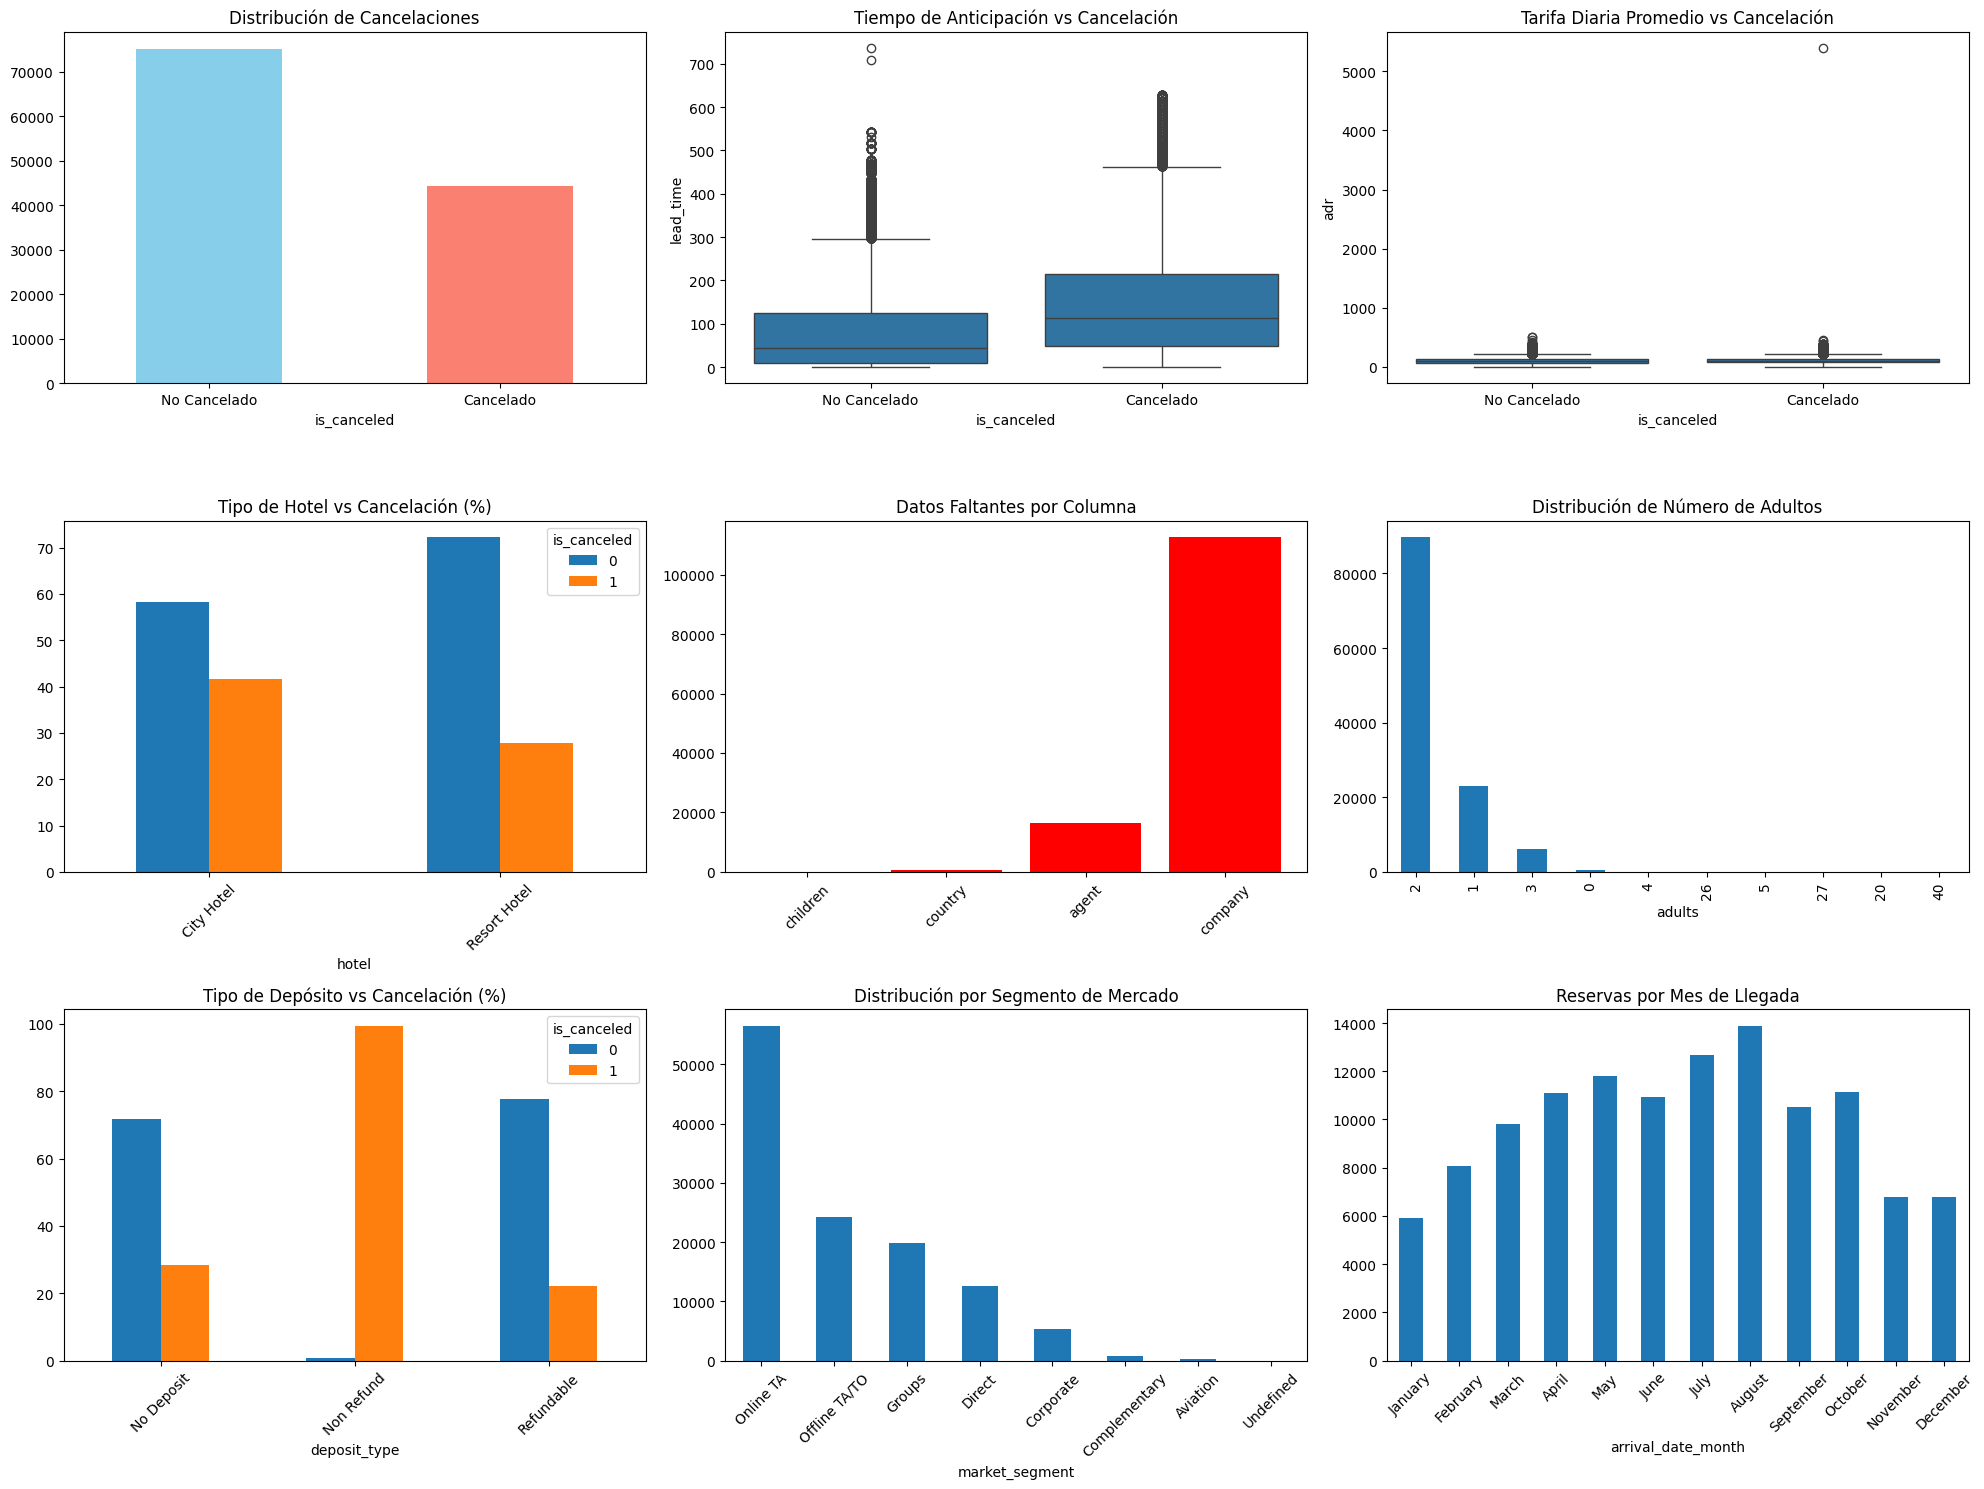

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

def create_visualizations(df, numeric_vars, categorical_vars):
    """Crea visualizaciones clave del EDA"""
    print("\n" + "="*60)
    print("CREANDO VISUALIZACIONES")
    print("="*60)

    plt.figure(figsize=(20, 15))

    # 1. Distribución de cancelaciones
    plt.subplot(3, 3, 1)
    if 'is_canceled' in df.columns:
        df['is_canceled'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
        plt.title('Distribución de Cancelaciones')
        plt.xticks([0, 1], ['No Cancelado', 'Cancelado'], rotation=0)

    # 2. Lead time vs Cancelación
    plt.subplot(3, 3, 2)
    if 'lead_time' in df.columns and 'is_canceled' in df.columns:
        sns.boxplot(data=df, x='is_canceled', y='lead_time')
        plt.title('Tiempo de Anticipación vs Cancelación')
        plt.xticks([0, 1], ['No Cancelado', 'Cancelado'])

    # 3. ADR vs Cancelación
    plt.subplot(3, 3, 3)
    if 'adr' in df.columns and 'is_canceled' in df.columns:
        sns.boxplot(data=df, x='is_canceled', y='adr')
        plt.title('Tarifa Diaria Promedio vs Cancelación')
        plt.xticks([0, 1], ['No Cancelado', 'Cancelado'])

    # 4. Tipo de hotel vs cancelación
    plt.subplot(3, 3, 4)
    if 'hotel' in df.columns and 'is_canceled' in df.columns:
        hotel_cancel = pd.crosstab(df['hotel'], df['is_canceled'], normalize='index') * 100
        hotel_cancel.plot(kind='bar', ax=plt.gca())
        plt.title('Tipo de Hotel vs Cancelación (%)')
        plt.xticks(rotation=45)

    # 5. Datos faltantes
    plt.subplot(3, 3, 5)
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0]
    if len(missing_data) > 0:
        plt.bar(missing_data.index, missing_data.values, color='red')
        plt.title('Datos Faltantes por Columna')
        plt.xticks(rotation=45)
    else:
        plt.text(0.5, 0.5, 'No hay datos faltantes', ha='center', va='center')
        plt.title('Datos Faltantes')

    # 6. Distribución de adultos
    plt.subplot(3, 3, 6)
    if 'adults' in df.columns:
        df['adults'].value_counts().head(10).plot(kind='bar')
        plt.title('Distribución de Número de Adultos')

    # 7. Tipo de depósito vs cancelación
    plt.subplot(3, 3, 7)
    if 'deposit_type' in df.columns and 'is_canceled' in df.columns:
        deposit_cancel = pd.crosstab(df['deposit_type'], df['is_canceled'], normalize='index') * 100
        deposit_cancel.plot(kind='bar', ax=plt.gca())
        plt.title('Tipo de Depósito vs Cancelación (%)')
        plt.xticks(rotation=45)

    # 8. Segmento de mercado
    plt.subplot(3, 3, 8)
    if 'market_segment' in df.columns:
        df['market_segment'].value_counts().plot(kind='bar')
        plt.title('Distribución por Segmento de Mercado')
        plt.xticks(rotation=45)

    # 9. Mes de llegada
    plt.subplot(3, 3, 9)
    if 'arrival_date_month' in df.columns:
        month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                      'July', 'August', 'September', 'October', 'November', 'December']
        df['arrival_date_month'].value_counts().reindex(month_order).plot(kind='bar')
        plt.title('Reservas por Mes de Llegada')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig('hotel_bookings_eda.png', dpi=300, bbox_inches='tight')
    plt.show()

create_visualizations(df, numeric_vars, categorical_vars)

# Pipeline de pre-procesamiento

Definición de Variables y pipeline

In [115]:
# preprocessing_simple.py
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

class SimpleHotelPreprocessor:
    def __init__(self):
        self.preprocessor = None
        self.feature_names = None

        # DEFINIR VARIABLES
        self.numeric_features = [
            'lead_time', 'adr', 'adults', 'previous_cancellations'
        ]

        self.categorical_features = [
            'hotel', 'deposit_type', 'customer_type', 'market_segment'
        ]

    def create_pipeline(self):
        """Crea el pipeline de preprocesamiento"""

        # Pipeline para numéricas
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        # Pipeline para categóricas
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        # Ensamblar todo
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, self.numeric_features),
                ('cat', categorical_transformer, self.categorical_features)
            ],
            remainder='drop'
        )

        return self.preprocessor

    def fit_transform(self, X, y=None):
        """Entrena y transforma los datos"""
        if self.preprocessor is None:
            self.create_pipeline()

        X_processed = self.preprocessor.fit_transform(X, y)
        self.feature_names = self._get_feature_names()

        print(f" Transformación exitosa: {X.shape} → {X_processed.shape}")
        return X_processed

    def _get_feature_names(self):
        """Obtiene nombres aproximados de features - VERSIÓN CORREGIDA"""
        feature_names = self.numeric_features.copy()

        # Añadir nombres estimados para one-hot encoding
        for col in self.categorical_features:
            feature_names.append(f"{col}_encoded")

        return feature_names

Prueba de pipeline

In [116]:
def test_simple_pipeline(df):
    """Prueba el pipeline simplificado"""
    print(" INICIANDO PRUEBA DEL PIPELINE")
    print("=" * 50)

    preprocessor = SimpleHotelPreprocessor()

    # Separar features del target
    features = df.drop('is_canceled', axis=1) if 'is_canceled' in df.columns else df

    print(f" Datos originales: {features.shape}")

    # Aplicar pipeline
    X_processed = preprocessor.fit_transform(features)

    print(f" Datos transformados: {X_processed.shape}")
    print(f" Features generadas: {len(preprocessor.feature_names)}")
    print(" Primeras 10 features:", preprocessor.feature_names[:10])

    return X_processed, preprocessor

In [117]:
# EJECUTAR PARA PROBAR:
df_processed, preprocessor = test_simple_pipeline(df)

 INICIANDO PRUEBA DEL PIPELINE
 Datos originales: (119390, 31)
 Transformación exitosa: (119390, 31) → (119390, 21)
 Datos transformados: (119390, 21)
 Features generadas: 8
 Primeras 10 features: ['lead_time', 'adr', 'adults', 'previous_cancellations', 'hotel_encoded', 'deposit_type_encoded', 'customer_type_encoded', 'market_segment_encoded']


El pipeline implementado resolvió exitosamente los hallazgos del EDA al transformar las 8 variables clave identificadas -lead_time, adr, adults, previous_cancellations, hotel, deposit_type, customer_type y market_segment- reduciendo la dimensionalidad de 31 a 21 features mediante codificación one-hot y escalado robusto, manteniendo intactas las 119,390 observaciones y dejando los datos listos para el modelado predictivo de cancelaciones con una tasa objetivo del 37%.